## PROCESSING PIPELINE

In [89]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**SETUP**

In [109]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

/home/farouk/anaconda3/envs/py3-9/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40939 instead
  warnings.warn(


LocalCluster(bb9142bb, 'tcp://127.0.0.1:41187', workers=4, threads=8, memory=7.66 GiB)

### BeerAdvocate - users.csv

**[I] Loading the Data**

In [91]:
users_cols = [
    "nbr_ratings", 
    "nbr_reviews", 
    "user_id", 
    "user_name", 
    "joined",
    "location"]

users_df = ing.read_csv(
    path=ing.build_path(folderind="ba", fileind="users"),
    assume_missing=True,
    keepcols=users_cols)

users_df.head(5)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820.0,465.0,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521.0,2504.0,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797.0,1143.0,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31.0,31.0,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604.0,604.0,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


**[II] Data Transformation**

Renaming the columns

In [92]:
cols_renaming = {
    "nbr_ratings": "n_ratings",
    "nbr_reviews": "n_reviews",
    "user_id": "uid",
    "user_name": "username"
}

users_df = users_df.rename(columns=cols_renaming)
users_df.columns

Index(['n_ratings', 'n_reviews', 'uid', 'username', 'joined', 'location'], dtype='object')

Converting data types

In [93]:
users_df.dtypes

n_ratings    float64
n_reviews    float64
uid           object
username      object
joined       float64
location      object
dtype: object

In [94]:
users_dtypes = {
    "n_ratings": np.int32, 
    "n_reviews": np.int32, 
    "uid": str, 
    "username": str,
    "location": str
}

users_df = users_df.astype(users_dtypes)
users_df.dtypes

n_ratings      int32
n_reviews      int32
uid           object
username      object
joined       float64
location      object
dtype: object

Converting "nan" strings in "location" to None

In [99]:
users_df["location"] = users_df.location.apply(prc.str_nan_to_none)

Converting the "joined" column values (time in seconds) to Timestamps

In [96]:
users_df["joined"] = ddf.to_datetime(users_df.joined, unit="s")
users_df.head(5)

,n_ratings,n_reviews,uid,username,joined,location
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 10:00:00,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 11:00:00,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,2003-11-20 11:00:00,Northern Ireland


In [100]:
# CHECK
print("CHECK: max date year must be at most 2017, the last year data was collected.")
users_df.joined.max()

CHECK: max date year must be at most 2017, the last year data was collected.


Timestamp('2017-07-31 10:00:00')

Appending the Country of Each Territory

In [102]:
users_df["country"] = users_df["location"].apply(lambda territory: prc.country_of(territory))
users_df.head(5)

,n_ratings,n_reviews,uid,username,joined,location,country
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 10:00:00,Northern Ireland,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 11:00:00,Northern Ireland,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,2003-11-20 11:00:00,Northern Ireland,Northern Ireland


**[III] Descriptive Statistics & Distributions**

Summary:

- No missing values, except for "location" and "joined".
  
- $153'704$ unique users.

- $\approx 73.6\%$ of users are located in the US, while $\approx 20.3\%$ are of unknown locatio, and the remaining $\approx 5.9\%$ is spread over 144 territories (mostly countries).

- high standard deviation for the number of reviews and the number of ratings.

- $50\%$ of users have at most 3 ratings, and no review.

- the highest number of ratings and the highest number of reviews by a user (not necessarily the same user) are $12'046$ and $8'970$ respectively.

In [103]:
users_df.describe()

,n_ratings,n_reviews
count,153704.000000,153704.000000
mean,54.605163,16.847876
std,252.388790,139.846706
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,16.000000,2.000000
max,12046.000000,8970.000000


user_id

In [104]:
print("Is any user ID missing ?")
users_df.uid.isna().any()

Is any user ID missing ?


False

In [105]:
print("How many unique users ?")
n_users = len(users_df.uid.unique())
n_users

How many unique users ?


153704

location

In [108]:
print("Is there a user with unknown location ?")
users_df.location.isna().any()

Is there a user with unknown location ?


True

In [111]:
print("How many users have an unknown location ?")
n_users_unknown_loc = users_df.location.isna().sum()
n_users_unknown_loc

How many users have an unknown location ?


31279

In [113]:
print("What fraction do these users make up of the total number of users ?")
n_users_unknown_loc / n_users

What fraction do these users make up of the total number of users ?


0.2035015354187269

In [115]:
print("How many users are located in the US ?")
n_users_usa_loc = (users_df.country == "United States").sum()
n_users_usa_loc

How many users are located in the US ?


113223

In [117]:
print("What fraction do these users make up of the total number of users ?")
n_users_usa_loc / n_users

What fraction do these users make up of the total number of users ?


0.7366301462551398

In [118]:
print("What fraction do the user with known location that is not the US make up of the total number of users ?")
1 - (n_users_usa_loc + n_users_unknown_loc) / n_users

What fraction do the user with known location that is not the US make up of the total number of users ?


0.059868318326133374

In [144]:
print("Where are all users located ?")
all_countries = users_df.country[~users_df.country.isna()].unique()
all_countries.sort()
all_countries

Where are all users located ?


array(['Afghanistan', 'Albania', 'American Samoa', 'Andorra', 'Angola',
       'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Aotearoa',
       'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Bermuda', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Bouvet Island', 'Brazil',
       'British Indian Ocean Territory', 'Bulgaria', 'Burkina Faso',
       'Cambodia', 'Canada', 'Cayman Islands', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'England', 'Equatorial Guinea', 'Estonia',
       'Ethiopia', 'Faroe Islands', 'Fiji Islands', 'Finland', 'France',
       'Germany', 'Gibraltar', 'Greece', 'Guam', 'Guatemala', 'Guernsey',
       'Haiti', 'Heard and McDonald Islands', 'Honduras', 'Hong Kong',
       'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland',
       'Isle of Man', 

In [145]:
print("How many different locations are there ?")
len(all_countries)

How many different locations are there ?


145

<AxesSubplot:xlabel='country'>

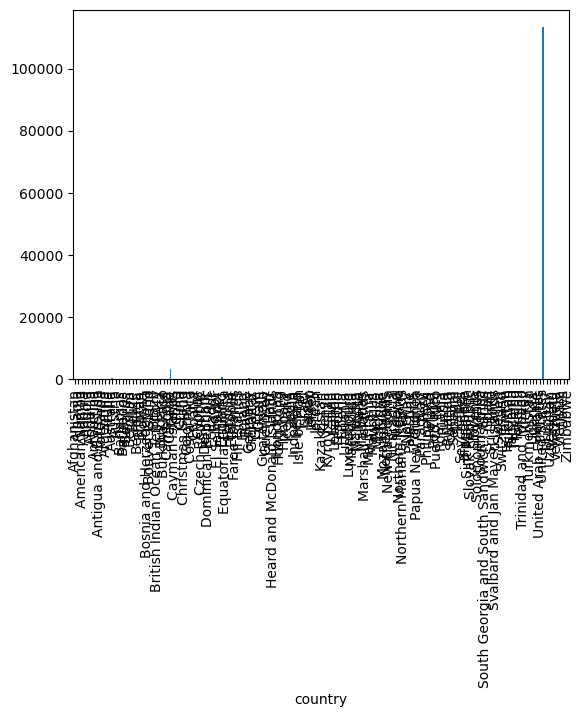

In [167]:
n_users_per_country = users_df[~ users_df.country.isna()].groupby("country").size()
n_users_per_country.plot.bar()

n_ratings

In [ ]:
print("Is there a user with unknown number of ratings ?")
users_df.n_ratings.isna().any()

Is there a user with unknown number of ratings ?


False

<AxesSubplot:title={'center':'Distribution of Ratings Across All Users'}, xlabel='ratings', ylabel='occurences'>

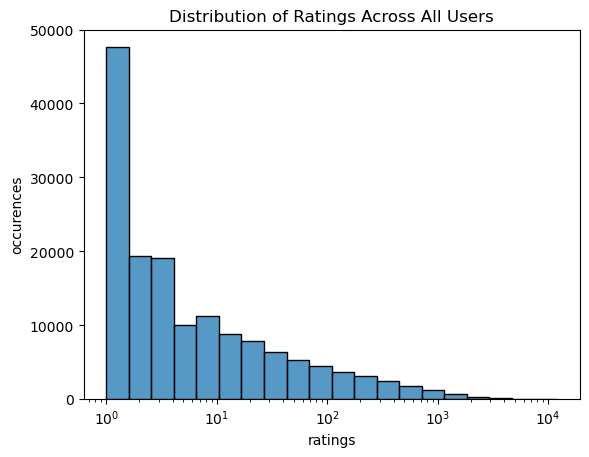

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_title("Distribution of Ratings Across All Users")
ax.set_ylabel("occurences")
ax.set_xlabel("ratings")
sns.histplot(data=users_df, x="n_ratings", ax=ax, bins=20, log_scale=True)


n_reviews

In [ ]:
print("Is there a user with unknown number of ratings ?")
users_df.n_reviews.isna().any()

Is there a user with unknown number of ratings ?


False

/home/farouk/anaconda3/envs/py3-9/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Distribution of Reviews Across All Users'}, xlabel='reviews', ylabel='occurences'>

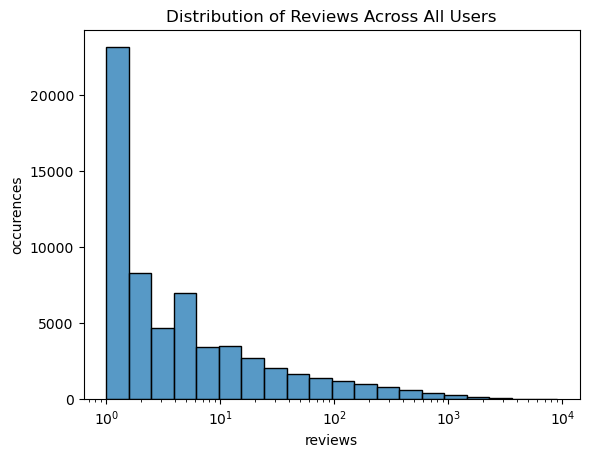

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_title("Distribution of Reviews Across All Users")
ax.set_ylabel("occurences")
ax.set_xlabel("reviews")
sns.histplot(data=users_df, x="n_reviews", ax=ax, bins=20, log_scale=True)

joined

[IV] Distributions